run pip install qiskit on command line if you do not have qiskit installed

This file is intended to have as little dependency on qiskit as possible and is entirely original work. everything up to the energy curve is correct for all examples. pseudocodes for some of the algorithms are provided in chapter 9, but I didnt have time to match the algorithms names (sorry) so you might need some guesswork. 

In [72]:
import numpy as np
from math import pi
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from scipy.optimize import minimize
%config InlineBackend.figure_format = 'svg'

This notebook includes all implemented functions in the Implementations section in the main capstone file. Note that we used two different methods to encode Jordan Wigner and Parity mappings, and in this notebook we will use the binary instead of the string notation. 

### Table of Contents

* [Construct Reference State](#hf)



* [Algorithm: Binary Mapping](#JW-mapping)

    * [Jordan-Wigner Mapping](#JW-mapping)
    
    * [Parity Mapping](#parity)


* [Algorithm: Pauli Product](#General)


* [Algorithm: Merge](#merge)


* [Algorithm: Operator Product](#general_op_prod)


* [Algorithm: AntiHermitian Operator](#sso)


* [Algorithm: (adapted) Phase Gadget](#todo_phasegadget)


* [Algorithm: Build VarForm](#build_var_form)


* [Method: Two Qubit Reduction](#tqr)


* [Algorithm: Get Hamiltonian](#ham)


* [Method: Computing Commutators](#com)


* [Algorithm: Measure Basis](#meas)


* [Algorithm: Get Energy](#syn)
    * [H2](#h2)

* [Method: Classical exact eigensolver](#exact)

### Construct Reference State <a class="anchor" id="hf"></a>

In [25]:
#This function constructs the Hartree-Fock reference state used for all variational methods. 

#using qiskit's notation for alpha and beta spin electrons, the first N/2 half will denote spin-ups, and second half for spin-downs. 

#mapping type is accounted for with the "parity" function: for jordan wigner we can just copy the vector. 
def HF(Nbits, Nelectrons,mapping_type):
    #constructs the parity mapping matrix
    def parity(n):
        matrix = np.zeros((n,n))
        for i in range(n):
            for j in range(i+1):
                matrix[i][j] = 1
        return matrix
    if Nbits%2 != 0 or Nelectrons%2 != 0:
        raise ValueError("num_orbital not an even integer")
    #number of alpha electrons: serves as the divide index since first N/2 qubits denote spin up electrons
    num_alpha = int(Nbits/2)
    num_occ = int(Nelectrons/2)
    statevector = np.zeros((Nbits,1))
    for orbital in range(num_occ): 
        #fill up the spin orbital representation 
        statevector[orbital] = 1
        statevector[orbital+num_alpha] = 1
    if mapping_type == "jordan_wigner":
        #flatten: gives us the exact same vector
        statevector = statevector.flatten()
    elif mapping_type == "parity":
        #parity: mapped by matrix, divided by 2. 
        statevector = (parity(Nbits)@statevector%2).flatten()
    qc = QuantumCircuit(Nbits)
    for occupation in range(len(statevector)):
        if statevector[occupation]: 
            qc.u3(pi,-pi/2,pi/2,occupation)
    return qc

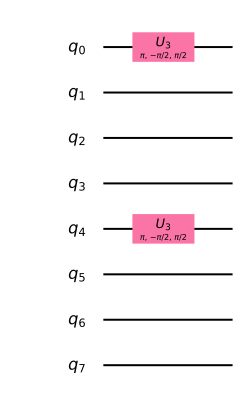

In [26]:
HF(8,4,"parity").draw("mpl")

### Jordan-Wigner mapping of creation and annihilation operators: 1/2(Z...)(Q+)(I...) <a class="anchor" id="JW-mapping"></a>

The qubit mapping methods (corresponding to the sections named Jordan-Wigner and Information Locality and Parity)

In [3]:
## GENERALLY CORRECT: assumes Jordan-Wigner and thus only one Y-gate.

#takes n bits, index of operator, and type of operator
#for instance: jw_bin(4,3,"creation) constructs the representation of
#the creation orbital in the (indexed 3) 4th orbital in a 4 spin orbital system

#returns the bit-string representation of the operator and the phase
#argument delta doesn't actually do anything in this case, since we already know the phase of 
#the Y gate in qubit raising and lowering operators. Might be more useful in parity or bravyi kitaev?

#definition: weighted pauli operator = (array, coef)

#notation: see Notations subsection at Implementations

def jw_bin(Nbits, index,operator_type):
    #initialize arrays
    op1_alpha = []
    op1_beta = []
    op2_alpha = []
    op2_beta = []
    
    #minus sign if operator is creation
    eps1 = 1/2
    eps2 = -1/2 if operator_type == "creation" else 1/2
    
    #append the encoded single qubit Pauli operators according to qubit mapping
    for qubit in range(index):
        op1_alpha.append(1)
        op1_beta.append(0)
        # 10 stands for Z gate, which keeps track of phase
        op2_alpha.append(1)
        op2_beta.append(0)
        #same as ^ above
    op1_alpha.append(0)
    op1_beta.append(1)
    #X
    op2_alpha.append(1)
    op2_beta.append(1)
    #iY
    for qubit in range(Nbits-index-1):
        op1_alpha.append(0)
        op1_beta.append(0)
        op2_alpha.append(0)
        op2_beta.append(0)
        #identities
        
        #return the TWO weighted Pauli operators resulting from this mapping method as a list. we will 
        # have to access and range over elements of these lists to perform operator products.
    return [[np.array([op1_alpha,op1_beta]),eps1], [np.array([op2_alpha,op2_beta]),eps2]]

In [4]:
#demonstration: data structure corresponding to a creation operator
jw_bin(4,2,"creation")

[[array([[1, 1, 0, 0],
         [0, 0, 1, 0]]), 0.5], [array([[1, 1, 1, 0],
         [0, 0, 1, 0]]), -0.5]]

### Parity Mapping of Qubit operators <a class="anchor" id="parity"></a>

In [5]:
#GENERALLY CORRECT
#parity method.
def parity_bin(Nbits, index,operator_type):
    op1_alpha = []
    op1_beta = []
    op2_alpha = []
    op2_beta = []

    eps1 = 1/2
    
    ### negative sign if operator is creation: III...(Z_(i-1)X_(i)-iY_(i))X..X
    eps2 = -1/2 if operator_type == "creation" else 1/2
    
    ### Identity gates for 0 to i-1. t_00 = I
    for qubit in range(index-1):
        op1_alpha.append(0)
        op1_beta.append(0)
        op2_alpha.append(0)
        op2_beta.append(0)
    
    ### Z_{i-1) \otimes I_{i-1} 
    
    ### if index is 0, then the Z gate is not needed since the parity of all occupations before the 0-th qubit is automatically 0 (Even).
    if index != 0:
        op1_alpha.append(1)
        op1_beta.append(0)
        op2_alpha.append(0)
        op2_beta.append(0)
    
    ### X_{i) \otimes Y_{i} 
    op1_alpha.append(0)
    op1_beta.append(1)
    op2_alpha.append(1)
    op2_beta.append(1)
    
    for qubit in range(Nbits-index-1):
        op1_alpha.append(0)
        op1_beta.append(1)
        op2_alpha.append(0)
        op2_beta.append(1)
    return [[np.array([op1_alpha,op1_beta]),eps1], [np.array([op2_alpha,op2_beta]),eps2]]

In [6]:
parity_bin(4,2,"annihilation")

[[array([[0, 1, 0, 0],
         [0, 0, 1, 1]]), 0.5], [array([[0, 0, 1, 0],
         [0, 0, 1, 1]]), 0.5]]

### General Pauli product <a class="anchor" id="General"></a>

In [7]:
#GENERALLY CORRECT
def op_bin(op1,op2,N):
    #returns the product of two pauli strings in \tau basis
    #arg structure: op1 first element is binary representations of operators, second is a list containing eps and delt.
    
    op1_bitstring = op1[0]
    op2_bitstring = op2[0]
    #we will perform binary array addition on the "pure" Pauli operator parts
    
    coef1 = op1[1]
    coef2 = op2[1]
    #and scalar multiplication on coefficients
    
    #output operator: addition mod 2
    op = op1_bitstring ^ op2_bitstring
    
    #multiply coefficients
    coef = coef1*coef2
    
    #corresponds to the term (-1)^(a[2].T b[1] )
    extra_phase = int(sum(op1_bitstring[1] & op2_bitstring[0])%2)
    
    eps = coef*(-1)**extra_phase
    
    return [op,eps]

In [8]:
op1 = [np.array([[1,0],[1,1]]),1]
op2 = [np.array([[1,1],[1,0]]),1]

demonstration: multiplication of Pauli operators  $iY\otimes X$ and $iY\otimes Z$. The result is $iI\otimes Y$.

In [10]:
#as desired! 
#first column (0,0) is the identity, 
#remember that a column that says (1,1) actually corresponds to iY. 
op_bin(op1,op2,1)

[array([[0, 1],
        [0, 1]]), 1]

### Algorithm: Merge <a class="anchor" id="merge"></a>

In [11]:
#helper functions: helps uniquely identify a Pauli operator by converting 
#the array into a decimal number. 

#Since the mapping from binary to decimal is BIJECTIVE, this will work just fine. 

def tobin(a):
    #convert an array to integer
    a = a.flatten()
    return int(a.dot(2**np.arange(a.size)[::-1]))

def tobin_inv(integer,Nbits):
    #convert integer to array
    bin_rep = [int(x) for x in list('{0:0b}'.format(integer))]
    for i in range(2*Nbits-len(bin_rep)):
        bin_rep.insert(0,0)
    return np.array(bin_rep).reshape(2,Nbits)

In [12]:
## This right here is the implementation of MERGE. 

def cleanup(operator_paulis,Nbits):
    operators = np.array([tobin(item[0]) for item in operator_paulis])

    coefs = np.array([item[1] for item in operator_paulis])
    
    unique_ind = np.unique(operators,return_index = True)[1]
    
    #find all the Pauli operators present
    counter = operators[unique_ind]

    coef_list = np.zeros(len(unique_ind))
    for op in range(len(operators)):
        for ind in range(len(counter)): 
            if operators[op] == counter[ind]:
                #add every weighted Pauli operator's coefficient to the counter
                coef_list[ind] += coefs[op]
    
    return [[tobin_inv(counter[i],Nbits),coef_list[i]] for i in range(len(unique_ind)) if not np.isclose(coef_list[i],0,atol=1e-7)]

### General Operator Product <a class="anchor" id="general_op_prod"></a>

In [14]:
#Implements the algorithm Operator Product. 
def build_qubit_op(excitation_list,Nbits,mapping_type):
    if mapping_type not in ["parity","jordan_wigner"]:
        raise ValueError("Mapping type invalid")
    
    #the index which divides creation and annihilation operators
    divide_ind = int(len(excitation_list)/2)

    #last half of the excitation list contains the creation operator indices: create particles at higher energy orbitals
    creation_list = excitation_list[:divide_ind]

    #first half contains annihilation operator indices. 
    annihilation_list = excitation_list[divide_ind:]
    #print(annihilation_list)
    #initialize the list of final paulis by setting it to the first operator inthe sequence: the first annihilation operator in list.
    operator_paulis = parity_bin(Nbits, annihilation_list[-1],"annihilation") if mapping_type == "parity" else jw_bin(Nbits, annihilation_list[-1],"annihilation")
    
    annihilation_list = annihilation_list[:-1]

    #starting from the second annihilation operator, compute the pauli products iteratively:
    for operator_index in annihilation_list:
        #print(operator_index)
        #we will update operator_paulis to this list after each iteration
        update_pauli_list = []
        
        #the annihilation operator which will be left-multiplying the current operator
        left_op = parity_bin(Nbits,operator_index,"annihilation") if mapping_type == "parity" else jw_bin(Nbits,operator_index,"annihilation")
        
        #left_op only has two Paulis, but a for loop doesn't hurt
        for pauli_1 in left_op:
            
            #for every pauli in the current list:
            for pauli_2 in operator_paulis:
                pauli = op_bin(pauli_1,pauli_2,Nbits)
                pauli_bitstr = pauli[0]
                #delete identity
                #if np.count_nonzero(pauli_bitstr) != 0:
                #multiply them and append the result to the list
                update_pauli_list.append(pauli)
        
        #update the current list of paulis, and repeat (if there are any annihilation operators left).
        operator_paulis = update_pauli_list
        #print(operator_paulis)
    #after the annihilation operator step is complete, repeat the exact same procedures for creation operators. 
    for operator_index in creation_list[::-1]:
        
        #print(operator_index)
        update_pauli_list = []
        left_op = parity_bin(Nbits,operator_index,"creation") if mapping_type == "parity" else jw_bin(Nbits,operator_index,"creation")

        for pauli_1 in left_op:
            for pauli_2 in operator_paulis:
                pauli = op_bin(pauli_1,pauli_2,Nbits)
                pauli_bitstr = pauli[0]
                #if np.count_nonzero(pauli_bitstr) != 0:
                update_pauli_list.append(op_bin(pauli_1,pauli_2,Nbits))
        operator_paulis = update_pauli_list
        #print(operator_paulis)
    return cleanup(operator_paulis,Nbits)

In [15]:
#example: the number operator for the last occupational mode. 
#as we have computed, this operator is 1/2(I_4 - Z_4), in agreement with the result below.
thing =  build_qubit_op([3,3],4,"jordan_wigner")
thing

[[array([[0, 0, 0, 0],
         [0, 0, 0, 0]]), 0.5], [array([[0, 0, 0, 1],
         [0, 0, 0, 0]]), -0.5]]

### Skew Hermitian Operator <a class="anchor" id="sso"></a>

In [17]:
# computes the skew hermitian operator \tau_ij - \tau^dag_ij
def ucc_build_skew_hermitian_operator(excitation_list,Nbits,mapping_type):
    
    #tau_ij
    excitation_op = build_qubit_op(excitation_list,Nbits,mapping_type)
    
    #tau^dag_ij
    excitation_op_adj = build_qubit_op(excitation_list[::-1],Nbits,mapping_type)
    
    #minus sign ;)
    for item in excitation_op_adj:
        item[1] = item[1]*(-1)
    
    operator_paulis = excitation_op + excitation_op_adj
    
    #relies on the Merge function to perform the operator algebra. 
    return cleanup(operator_paulis,Nbits)

In [19]:
#example: a two body excitation operator adag_1adag_2a_3a_4
ucc_build_skew_hermitian_operator([0,1,2,3],4,"jordan_wigner")

[[array([[0, 0, 0, 1],
         [1, 1, 1, 1]]), -0.125], [array([[0, 0, 1, 0],
         [1, 1, 1, 1]]), -0.125], [array([[0, 1, 0, 0],
         [1, 1, 1, 1]]), 0.125], [array([[0, 1, 1, 1],
         [1, 1, 1, 1]]), 0.125], [array([[1, 0, 0, 0],
         [1, 1, 1, 1]]), 0.125], [array([[1, 0, 1, 1],
         [1, 1, 1, 1]]), 0.125], [array([[1, 1, 0, 1],
         [1, 1, 1, 1]]), -0.125], [array([[1, 1, 1, 0],
         [1, 1, 1, 1]]), -0.125]]

### Phase gadget <a class="anchor" id="todo_phasegadget"></a>

In [20]:
#same implementation as described in PhaseGadget 1 in main document. 
def phase_gadget(qc,nbits,op,alpha):
    
    pauli = op[0]
    coef = op[1]
    phase = np.sign(coef)
    #the bit string component of the pauli

#   phase = pauli[1]
#     if phase[1] != 0:
#         raise ValueError("Pauli operator not unitary!")
    op_bitstr_1 = pauli[0]

    op_bitstr_2 = pauli[1]

    pauli_x_list = []
    pauli_y_list = []
    pauli_z_list = []
    pauli_i_list = []
    
    for qbit in range(nbits):
        if op_bitstr_1[qbit] == 0 and op_bitstr_2[qbit] == 0:
            pauli_i_list.append(qbit)
        elif op_bitstr_1[qbit] == 0 and op_bitstr_2[qbit] == 1:
            pauli_x_list.append(qbit)
        elif op_bitstr_1[qbit] == 1 and op_bitstr_2[qbit] == 1:
            pauli_y_list.append(qbit)
        elif op_bitstr_1[qbit] == 1 and op_bitstr_2[qbit] == 0:
            pauli_z_list.append(qbit)
    
    nontrivial_list = [i for i in range(nbits) if i not in pauli_i_list]
    
    for qbit in pauli_x_list:
        qc.u2(0,pi,qbit)
    for qbit in pauli_y_list:
        qc.u3(pi/2,-pi/2,pi/2,qbit)
    #qc.barrier()
    for qbit_ind in range(len(nontrivial_list)-1):
        qc.cx(nontrivial_list[qbit_ind],nontrivial_list[qbit_ind+1])
    #qc.barrier() 
    qc.rz(phase*alpha, nontrivial_list[-1])
    #qc.barrier()
    for qbit_ind in range(len(nontrivial_list)-1,0,-1):
        qc.cx(nontrivial_list[qbit_ind-1],nontrivial_list[qbit_ind])
    #qc.barrier()
    for qbit in pauli_x_list:
        qc.u2(0,pi,qbit)
    for qbit in pauli_y_list:
        qc.u3(-pi/2,-pi/2,pi/2,qbit)
    #qc.barrier()
    return qc
            
        

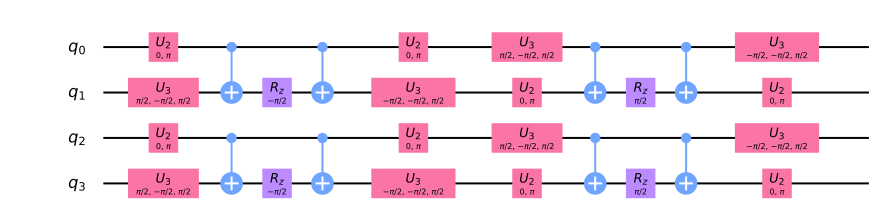

In [23]:
#demonstration of phase gadget applied for single excitations:
qc = QuantumCircuit(4)
excitation_op = ucc_build_skew_hermitian_operator([1,0],4,"jordan_wigner")
excitation_op1 = ucc_build_skew_hermitian_operator([3,2],4,"jordan_wigner")
for op in excitation_op:
    phase_gadget(qc,4,op,pi/2)
for op in excitation_op1:
    phase_gadget(qc,4,op,pi/2)
qc.draw("mpl")

### Build Variational Form <a class="anchor" id="build_var_form"></a>

In [24]:
### we need a function which takes a list of excitations, assigns a variable to each antihermitian op, and builds the var form:

def build_var_form(qc,Nbits,excitation_list,var,reps,mapping_type):
    if len(var) % len(excitation_list)!= 0: 
        raise ValueError("please match the number of variables to the number of operators")
    
    if reps != len(var)/len(excitation_list):
        raise ValueError("number of variables do not match the number of excitation operators times reps")
    
    #parameter reps denotes the k in k-UpUCCSD. sacrifices computational time for (in theory) more accuracy.
    var = np.split(np.array(var),reps)
    
    num_op = len(excitation_list)
    
    op_list = []
    
    #compute the list of qubit operators
    for excitation in excitation_list:
        op_list += [ucc_build_skew_hermitian_operator(excitation,Nbits,mapping_type)]
    
    #compile circuit
    for var_rep in var:
        for op_ind in range(len(op_list)): 
            op = op_list[op_ind]
            var_op = var_rep[op_ind]
            for pauli in op:
                phase_gadget(qc,4,pauli,var_op)
    
    return qc

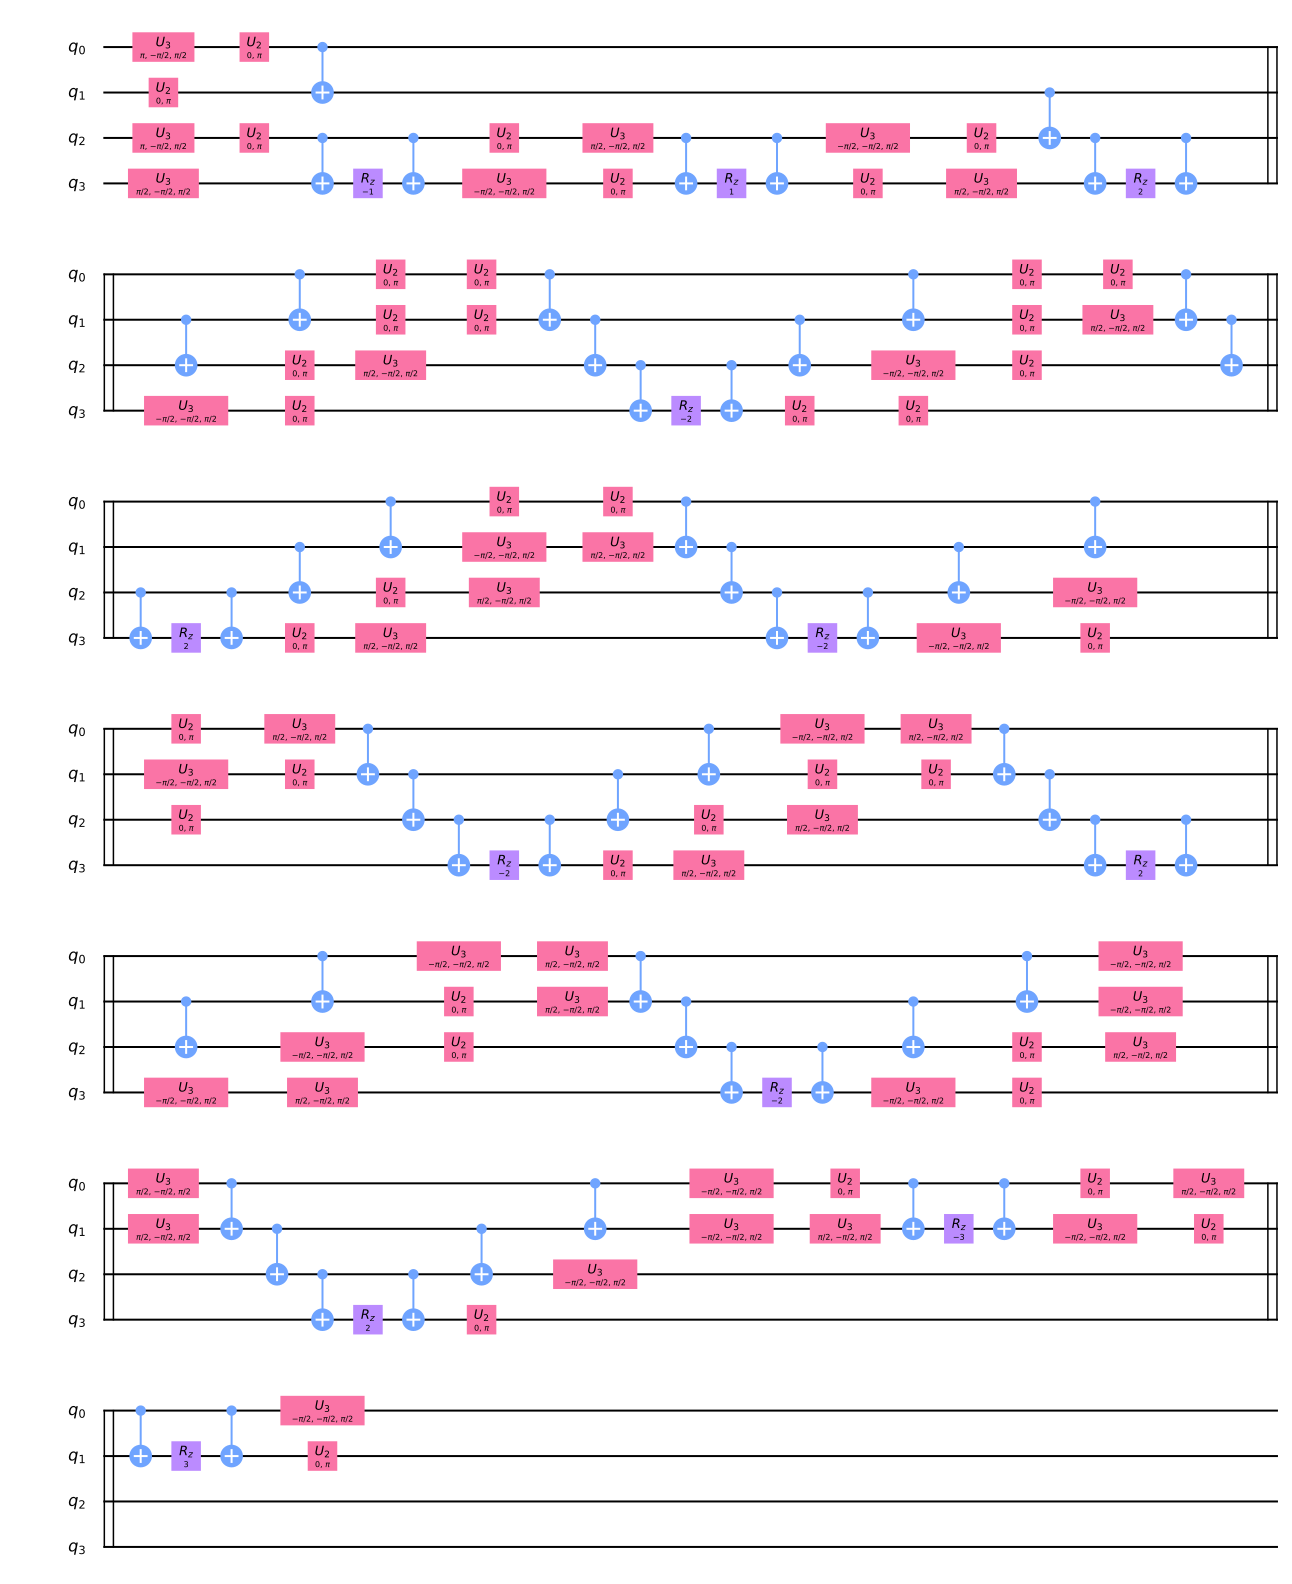

In [54]:
build_var_form(HF(4,2,"jordan_wigner"),4,[[3,2],[3,1,2,0],[1,0]],[1,2,3],1,"jordan_wigner").draw("mpl")

### Two Qubit Reduction <a class="anchor" id="tqr"></a>

Something is not right about this, and I am trying to find out what it is. I haven't used this in any of the calculations, though in principle this will be IMMENSELY helpful for every calculation below, IF it works. 

In [29]:
### takes a mapped operator and transforms it into two-qubit-reduced operator. 

## reduction_list has two sublists, the first must specify the indices of the reduced qubits in the original operator;

## the second indicates the occupancy of these reduced qubits in the HF reference state (how might we generalize to multi-reference method?)

## example input: op = ucc_build_skew_hermitian_operator(excitation_list,Nbits,mapping_type), reduction_list = [[1,3],[1,0]].

def tqr_operator_transformation(op,reduction_list,Nbits):
    #reduction indices MUST be in increasing order like[1,3]. Anything else and the code BREAKS! I dont wanna fix it so just let it be lol
    reduction_indices = reduction_list[0]
    if reduction_indices[1] < reduction_indices[0]:
        raise ValueError("Reduction Index ordering not suitable: pls use increasing index number!")
    reduction_occupations = reduction_list[1]
    reduced_op = []
    
    #each pauli is transformed differently: every pauli is redacted at the same two indices, but some get a different phase than others. 
    
    for pauli in op:
        
        # the (-1) and (i) phases of this pauli
        coef = pauli[1]
        
        # find the bitstring representation of the pauli
        op_bitstr = pauli[0]
        op_bitstr_1 = op_bitstr[0]
        op_bitstr_2 = op_bitstr[1]
        pauli_i_list = []
        
        # find indices at which this particular pauli acts trivially
        for qbit in range(Nbits):
            if op_bitstr_1[qbit] == 0 and op_bitstr_2[qbit] == 0:
                pauli_i_list.append(qbit)
            
        # find the intersection between the nontrivial pauli locations and the reduced qubits
        phase_correction_list = [reduction_occupations[i] for i in range(2) if reduction_indices[i] not in pauli_i_list]
        
        # the phase correction is the sum of occupation states in this intersection
        phase_correction = int(sum(phase_correction_list)%2)

        #update the correct phase
        coef = coef*(-1)**(phase_correction)
        
        #delete the paulis operating on the reduced qubits
        op_bitstr = np.delete(op_bitstr,reduction_indices,1)
        
        #compound the reduced pauli with its new phase into a format consistent with phase_gadget and other functions. 
        transformed_pauli = [op_bitstr,coef]
        
        #add it to the list of Paulis
        reduced_op.append(transformed_pauli)
        
    return cleanup(reduced_op,Nbits-2)

In [31]:
#checked, this is the same result that Qiskit gives for H2 at 0.735, parity mapping. But SOMETHING just isn't right and I'Il use it when it's all fixed. 
# Hamiltonian1 = get_qubit_hamiltonian([h1,h2],4,"parity")
# tqr_operator_transformation(Hamiltonian1,[[1,3],[1,0]],4)

### Mapping Hamiltonian <a class="anchor" id="ham">

In [36]:
## obtain one and two body integrals using qiskit

from qiskit.chemistry.drivers import PySCFDriver, UnitsType

molecular_coordinates = 'H 0 0 0; H 0.735 0 0'

distance_unit = UnitsType.ANGSTROM

basis = 'sto3g'

driver = PySCFDriver(molecular_coordinates, unit=distance_unit)

molecule = driver.run()

h1 = molecule.one_body_integrals

h2 = molecule.two_body_integrals

In [39]:
### Maps Hamiltonian:
#h2[i,j,k,l] <-> adag_i,adag_k,a_l,a_j#

def get_qubit_hamiltonian(ham,Nbits,mapping_type):
    #Hamiltonian H is input as [h1,h2]
    #chemist notation: h2(i,j,k,l) –> adag_i adag_k a_l a_j
    h1 = ham[0]
    h2 = ham[1]
    
    #ONLY the nonzero components matter. These matrices are quite sparse. 
    one_body = np.nonzero(h1)
    two_body = np.nonzero(h2)
    num_onebody = len(one_body[0])
    num_twobody = len(two_body[0])
    
    #obtain the list of indices which will be used to pair the integrals to the operators
    one_body_indices = np.array(one_body)
    two_body_indices = np.array(two_body)
    
    #initialize empty Hamiltonian operator
    qubit_hamiltonian = []
    
    #for each entry, build the corresponding one body operator
    for op_index in range(num_onebody):
        #each column corresponds to the indices of each operator
        excitation_list = one_body_indices[:,op_index]
        #so build that operator!
        op_paulis = build_qubit_op(excitation_list,Nbits, mapping_type)
        #and if this operator is non-zero (turns out a decent amount of them are):
        if op_paulis:
            
            op_coef = h1[excitation_list[0],excitation_list[1]]
            
            if not np.isclose(op_coef,0,atol = 1e-6):
                
                for pauli in op_paulis:
                    #for each weighted Pauli operator, its weight is modified by the integrals
                    pauli[1]*= op_coef
                #aaand it's good enough to go into the qubit Hamiltonian as a one body term!
                qubit_hamiltonian += op_paulis
                
    #two body           
    for op_index in range(num_twobody):
        excitation_list = two_body_indices[:,op_index]
        #chemist notation: fixes an inconsistency between qiskit's integrals notation and the operator product notation we use. 
        chemist = [excitation_list[0],excitation_list[2],excitation_list[3],excitation_list[1]]
        
        op_paulis = build_qubit_op(chemist,Nbits, mapping_type)
        
        if op_paulis:
            
            op_coef = h2[excitation_list[0],excitation_list[1],excitation_list[2],excitation_list[3]]
            
            if not np.isclose(op_coef,0,atol = 1e-6):
                
                for pauli in op_paulis:

                    pauli[1]*= op_coef
                qubit_hamiltonian += op_paulis
    #one final cleanup
    return cleanup(qubit_hamiltonian,Nbits)

In [41]:
#The qubit Hamiltonian of hydrogen molecule! 
ham = get_qubit_hamiltonian([h1,h2],4,"jordan_wigner")
ham

[[array([[0, 0, 0, 0],
         [0, 0, 0, 0]]), -0.8105479805373268], [array([[0, 0, 0, 0],
         [1, 1, 1, 1]]), 0.045232799946057854], [array([[0, 0, 0, 1],
         [0, 0, 0, 0]]), -0.22575349222402444], [array([[0, 0, 1, 0],
         [0, 0, 0, 0]]), 0.1721839326191555], [array([[0, 0, 1, 1],
         [0, 0, 0, 0]]), 0.1209126326177663], [array([[0, 0, 1, 1],
         [1, 1, 1, 1]]), -0.045232799946057854], [array([[0, 1, 0, 0],
         [0, 0, 0, 0]]), -0.2257534922240245], [array([[0, 1, 0, 1],
         [0, 0, 0, 0]]), 0.17464343068300453], [array([[0, 1, 1, 0],
         [0, 0, 0, 0]]), 0.16614543256382414], [array([[1, 0, 0, 0],
         [0, 0, 0, 0]]), 0.1721839326191554], [array([[1, 0, 0, 1],
         [0, 0, 0, 0]]), 0.16614543256382414], [array([[1, 0, 1, 0],
         [0, 0, 0, 0]]), 0.16892753870087912], [array([[1, 1, 0, 0],
         [0, 0, 0, 0]]), 0.1209126326177663], [array([[1, 1, 0, 0],
         [1, 1, 1, 1]]), -0.045232799946057854], [array([[1, 1, 1, 1],
         

In [55]:
#what if one of the Hydrogens was replaced by a Lithium? The number of spin orbitals would increase DRAMATICALLY 

#and our algorithm would take a bit longer. Qiskit tends to take quite a bit shorter than my programs and I don't know why 

#but this is ultimately necessary because there's no excitation operator sequencing option in qiskit. 
molecular_coordinates = 'H 0 0 0; Li 0.735 0 0'

distance_unit = UnitsType.ANGSTROM

basis = 'sto3g'

driver = PySCFDriver(molecular_coordinates, unit=distance_unit)

molecule_li = driver.run()

h_1 = molecule_li.one_body_integrals

h_2 = molecule_li.two_body_integrals

ham = get_qubit_hamiltonian([h_1,h_2],12,"jordan_wigner")

#yup, the qubit Hamiltonian got a LOT bigger with more orbitals.
len(ham)

631

### Commutator <a class="anchor" id="com"></a>

Computes the commutator of an antihermitian excitation operator $\hat{\tau}_{ij} - \hat{\tau}^{\dagger}_{ij}$ with the Hamiltonian. Haven't used it yet because the exact eigensolver isn't working perfectly. 

In [52]:
def build_commutator_with_hamiltonian(Nbits, excitation_op,Hamiltonian,mapping_type):
    ###Hamiltonian as output of get_qubit_hamiltonian
    ###excitationop as list of operator indicecs
    op_A = ucc_build_skew_hermitian_operator(excitation_op,Nbits,mapping_type)
    commutator_list = []
    for term1 in op_A:
        for term2 in Hamiltonian: 
            coef1 = term1[1]
            coef2 = term2[1]
            pauli1 = term1[0]
            pauli2 = term2[0]
            commutator_list += [op_bin([pauli1,coef1],[pauli2,coef2],Nbits)]
            commutator_list += [op_bin([pauli2,coef2],[pauli1,(-1)*coef1],Nbits)]
    return cleanup(commutator_list,Nbits)

In [53]:
#commutator of adag_1a_0 - adag_0a_1 with the H2 qubit Hamiltonian. 
ham = get_qubit_hamiltonian([h1,h2],4,"jordan_wigner")
com = build_commutator_with_hamiltonian(4,[1,0],ham,"jordan_wigner")
com

[[array([[0, 0, 0, 0],
         [1, 1, 0, 0]]), -0.3979374248431799], [array([[0, 0, 0, 1],
         [1, 1, 0, 0]]), 0.008497998119180394], [array([[0, 0, 1, 0],
         [1, 1, 0, 0]]), -0.002782106137054985], [array([[0, 1, 0, 0],
         [0, 0, 1, 1]]), -0.09046559989211571], [array([[0, 1, 1, 1],
         [0, 0, 1, 1]]), 0.09046559989211571], [array([[1, 0, 0, 0],
         [0, 0, 1, 1]]), 0.09046559989211571], [array([[1, 0, 1, 1],
         [0, 0, 1, 1]]), -0.09046559989211571], [array([[1, 1, 0, 0],
         [1, 1, 0, 0]]), 0.3979374248431799], [array([[1, 1, 0, 1],
         [1, 1, 0, 0]]), -0.008497998119180394], [array([[1, 1, 1, 0],
         [1, 1, 0, 0]]), 0.002782106137054985]]

### Measurements (qiskit) <a class="anchor" id="meas">

In [56]:
#just in case, idk how many functions from qiskit this uses but just Aer shouldn't be enough. 
from qiskit import * 

In [229]:
#Helper function which we HAVEN'T used yet so dont read it if you're tired. Using this is sooo hard :( 

#This gets the list of all Pauli bases we need to perform measurements in, 

#since some measurement results can be recovered from others. 


#returns a list of lists, each of which has the first element specifying which measurements we actually need. 

#this is because identities in the pauli dont affect anything... we dont measure those. So the result for (IZ) can be recovered from (ZZ), 

#saving us some computational power. 

# def get_measurement_bases(op):

#     sub_list = [[op[0]]]

#     def contains(pauli1,pauli2):
#         identity_list = []
#         #checks if pauli2's measurement results can be recovered from those of pauli1
#         for column in range(len(pauli2.T)):
#             if not np.any(pauli2[:,column]):
#                 identity_list.append(column)
#         #deletes the identities of pauli 2 (and pauli1's gates at those indices). If the remaining operators match, pauli 2 is strictly contained in pauli1. 
#         pauli1 = np.delete(pauli1,identity_list,1)
#         pauli2 = np.delete(pauli2,identity_list,1)
#         if np.array_equal(pauli1,pauli2):
#             return True
#         else: 
#             return False
        
#     for term in op[1:]:
#         pauli = term[0]
#         coef = term[1]
#         for item_ind in range(len(sub_list)):
#             item = sub_list[item_ind]

#             if contains(pauli,item[0][0]):
#                 sub_list[item_ind].insert(0,term)
#                 #print("inserted")
#                 break
#             elif contains(item[0][0], pauli):
#                 #print("appended")
#                 sub_list[item_ind].append(term)
#                 break
                

#             else: 
#                 #print("added")
#                 sub_list.append([term])
#                 break
                
        
#     return sub_list
            

In [57]:
# feel free to run this (command / to un-comment blocks of code on mac, god help you if you have a pc)
# op = commutator_with_hamiltonian([2,3],[h1,h2],8,"jordan_wigner")
# get_measurement_bases(op)

In [59]:
#implements Measure Basis function
def measure_true_simulator(qc,basis,shots = 1000):
    nbits = len(basis[0])
    
    #this here demonstrates THE EFFECTS OF MEASUREMENTS ON A QUANTUM SYSTEM!
    # measuring a qc destroys its state, so we need to COPY the circuit and perform the true simulator measurement on that clone circuit.
    qc_prep = qc.copy()
    
    backend = Aer.get_backend("qasm_simulator")
    
    #this will be the set of measurements we will need.
    op_bitstr = basis

    op_bitstr_1 = op_bitstr[0]
    op_bitstr_2 = op_bitstr[1]
    pauli_x_list = []
    pauli_y_list = []
    pauli_z_list = []
    pauli_i_list = []
    
    for qbit in range(nbits):
        #perform the single qubit rotations, same as phase gadget. 
        
        #So essentially we're operating in a different basis, except this time this operation is the projective measurement. 
        if op_bitstr_1[qbit] == 0 and op_bitstr_2[qbit] == 0:
            pauli_i_list.append(qbit)
        elif op_bitstr_1[qbit] == 0 and op_bitstr_2[qbit] == 1:
            pauli_x_list.append(qbit)
        elif op_bitstr_1[qbit] == 1 and op_bitstr_2[qbit] == 1:
            pauli_y_list.append(qbit)
        elif op_bitstr_1[qbit] == 1 and op_bitstr_2[qbit] == 0:
            pauli_z_list.append(qbit)
    
    for ind in pauli_x_list:
        qc_prep.u2(0,pi,ind)
    for ind in pauli_y_list:
        qc_prep.u3(pi/2,-pi/2,pi/2,ind)
    
    qc_prep.measure_all()
    
    result = execute(qc_prep,backend = backend, shots = shots).result().get_counts().items()
    
    nontrivial_bits = [i for i in range(nbits) if i not in pauli_i_list]
    
    result_bits = [item[0] for item in result]
    result_prob = np.array([item[1] for item in result])
    
    result_exp = []
    for item in result_bits:
        #trace over the result. 
        result_exp.append((-1)**(sum([int(item[i]) for i in range(nbits) if i not in pauli_i_list])))
    
    return np.array(result_exp).T@result_prob/sum(result_prob)
        

In [58]:
#measurement function for statevector simulator method. more efficient like this. 
def measure_statevector_simulator(qc,basis):
    def component_bin(integer,Nbits):
        bin_rep = [int(x) for x in list('{0:0b}'.format(integer))]
        for i in range(Nbits-len(bin_rep)):
            bin_rep.insert(0,0)
#         return np.array(bin_rep)
        return np.array(bin_rep)[::-1]
    nbits = len(basis[0])
    
    qc_prep = qc.copy()
    
    backend = Aer.get_backend("statevector_simulator")
    
    op_bitstr = basis

    op_bitstr_1 = op_bitstr[0]
    op_bitstr_2 = op_bitstr[1]
    pauli_x_list = []
    pauli_y_list = []
    pauli_z_list = []
    pauli_i_list = []
    
    for qbit in range(nbits):
        if op_bitstr_1[qbit] == 0 and op_bitstr_2[qbit] == 0:
            pauli_i_list.append(qbit)
        elif op_bitstr_1[qbit] == 0 and op_bitstr_2[qbit] == 1:
            pauli_x_list.append(qbit)
        elif op_bitstr_1[qbit] == 1 and op_bitstr_2[qbit] == 1:
            pauli_y_list.append(qbit)
        elif op_bitstr_1[qbit] == 1 and op_bitstr_2[qbit] == 0:
            pauli_z_list.append(qbit)
    
    for ind in pauli_x_list:
        qc_prep.u2(0,pi,ind)
    for ind in pauli_y_list:
        qc_prep.u3(pi/2,-pi/2,pi/2,ind)
    
    statevector = execute(qc,backend).result().get_statevector()
    
    #hey! here's te probabilistic interpretation of quantum mechanics!
    norm = np.absolute(statevector)
    prob = norm*norm
    
    parity = []
    for qubit in range(len(statevector)):
        state = component_bin(qubit,Nbits)
        parity_partial = sum([state[i] for i in range(len(state)) if i not in pauli_i_list])%2
        parity += [(-1)**(parity_partial)]
    
    #each basis which we can possibly measure corresponds to an expectation value of "virtual spin". this is represented by 
    # the parity of "1"s in the result, since each "1" is spin down and therefore contributes a negative sign. 
    #We add up the number of "1"s at the sites where Pauli doesn't say identity (measurements we dont skip), then pair that 
    #with the probability associated with each outcome. 
    return prob@np.array(parity)

### Get Energy <a class="anchor" id="syn">

#### Hydrogen molecule with UCCSD <a class="anchor" id="h2">

In [83]:
### get integrals

molecular_coordinates = 'H 0 0 0; H 0 0 0.735'

distance_unit = UnitsType.ANGSTROM

basis = 'sto3g'

driver = PySCFDriver(molecular_coordinates, unit=distance_unit)

molecule = driver.run()

h1 = molecule.one_body_integrals

h2 = molecule.two_body_integrals

In [62]:
# Hartree Fock state prep
qc = HF(4,2,"jordan_wigner")

In [63]:
#build excitation list: we include single and doubles

def get_energy(var,Hamiltonian,Nbits,Nelectrons,excitation_list,mapping_type, shots = 10000,method = "matmul"):
    if method not in ["matmul","qasm"]:
        raise TypeError("Please use a valid simulation method")
    if len(var)%len(excitation_list) !=0:
        raise ValueError("reps dont match length of excitation list")
    #hartree fock reference state
    init = HF(Nbits,Nelectrons,mapping_type)
    #k in k-UpUCC
    reps = int(len(var)/len(excitation_list))
    #construct circuit
    qc = build_var_form(init,Nbits,excitation_list,var,reps,mapping_type)
    #this counter variable is used for tracing (H\rho). 
    counter = 0
    for term in Hamiltonian:
        coef = term[1]
        if method == "matmul":
            counter += coef*measure_statevector_simulator(qc,term[0])
        else: 
            counter += coef*measure_true_simulator(qc,term[0],shots = shots)
    #this here is an actual ENERGY: the sum of all the electrons' energies
    return counter

In [65]:
#this function DIRECTLY solves for the ground state energy of H2. 
def h2(sep, excitation_list, mapping_type):
    
    #define the molecule: we're interested in the ground state energies at different nuclear separation distances.
    h2= PySCFDriver("H 0 0 0; H 0 0 " + str(sep), unit=UnitsType.ANGSTROM, basis='sto3g').run()

    #add the potentials of the nuclei due to themselves. thank physics for the superposition principle :))
    nre = h2.nuclear_repulsion_energy

    #obtain one and two body integrals
    integrals = [h2.one_body_integrals,h2.two_body_integrals]
    
    #construct Hamiltonian
    Ham = get_qubit_hamiltonian(integrals, 4,"jordan_wigner")
     
    #define the excitation operators
    excitation = excitation_list

    mapping = mapping_type
    
    #we need a lambda function because scipy minimize doesn't like functions with too many constant arguments. 
    energy = lambda var: get_energy(var, Ham, 4,2,excitation,mapping_type)

    obj = minimize(energy,[0,0],method = "COBYLA",tol = 1e-4)
    
    return obj.fun + nre

In [69]:
#kinda close to the real ground state energy but NOT QUITE. this var form isn't accurate enough but is good for demo. 
h2(0.735,[[3,2],[1,0]],"jordan_wigner")

-1.1169989890208578

In [75]:
#COMPUTES THE ENERY CURVE!
nucsep = np.arange(0.2,5.0,0.02)

In [1252]:
#takes forever to run, but the result I got this time is in the next cell so feel free to abort this if you trust me ;)
energies = np.array([])
for sep in nucsep:
    energies = np.append(energies,h2(sep,[[3,2],[1,0]],"jordan_wigner"))

In [70]:
# energies = np.array([ 0.16417503, -0.05303417, -0.22921849, -0.37384275, -0.49370739,
#        -0.59382774, -0.67798411, -0.74907861, -0.80937406, -0.86065852,
#        -0.90436138, -0.94163724, -0.97342754, -1.00050673, -1.02351722,
#        -1.04299626, -1.05939669, -1.07310308, -1.08444448, -1.09370431,
#        -1.10112823, -1.10693036, -1.11129819, -1.11439653, -1.11637069,
#        -1.11734903, -1.11744507, -1.1167593 , -1.11538065, -1.11338782,
#        -1.11085039, -1.10782989, -1.10438068, -1.1005508 , -1.09638272,
#        -1.09191404, -1.08717807, -1.08220447, -1.07701965, -1.07164728,
#        -1.06610864, -1.060423  , -1.05460785, -1.04867917, -1.04265166,
#        -1.03653887, -1.03035337, -1.02410685, -1.01781021, -1.01147364,
#        -1.0051067 , -0.99871834, -0.99231693, -0.98591034, -0.97950594,
#        -0.97311061, -0.96673079, -0.96037249, -0.9540413 , -0.94774241,
#        -0.94148065, -0.93526049, -0.92908605, -0.92296113, -0.91688923,
#        -0.91087355, -0.90491703, -0.89902234, -0.89319192, -0.88742796,
#        -0.88173245, -0.87610717, -0.87055372, -0.86507351, -0.85966779,
#        -0.85433763, -0.84908396, -0.84390759, -0.83880916, -0.83378921,
#        -0.82884815, -0.82398626, -0.81920375, -0.8145007 , -0.8098771 ,
#        -0.80533284, -0.80086776, -0.79648157, -0.79217395, -0.78794447,
#        -0.78379265, -0.77971796, -0.7757198 , -0.7717975 , -0.76795037,
#        -0.76417765, -0.76047856, -0.75685226, -0.75329789, -0.74981456,
#        -0.74640135, -0.74305731, -0.73978147, -0.73657286, -0.73343048,
#        -0.73035332, -0.72734036, -0.72439059, -0.72150296, -0.71867647,
#        -0.71591006, -0.71320272, -0.71055342, -0.70796114, -0.70542487,
#        -0.7029436 , -0.70051633, -0.69814206, -0.69581982, -0.69354864,
#        -0.69132756, -0.68915562, -0.6870319 , -0.68495545, -0.68292537,
#        -0.68094076, -0.67900072, -0.67710437, -0.67525085, -0.67343929,
#        -0.67166886, -0.66993872, -0.66824804, -0.66659602, -0.66498185,
#        -0.66340474, -0.66186392, -0.66035861, -0.65888807, -0.65745152,
#        -0.65604825, -0.65467752, -0.65333861, -0.65203081, -0.65075343,
#        -0.64950578, -0.64828717, -0.64709693, -0.64593441, -0.64479896,
#        -0.64368993, -0.6426067 , -0.64154864, -0.64051514, -0.6395056 ,
#        -0.63851943, -0.63755605, -0.63661489, -0.63569538, -0.63479698,
#        -0.63391913, -0.63306132, -0.63222302, -0.63140371, -0.63060291,
#        -0.62982011, -0.62905484, -0.62830662, -0.627575  , -0.62685953,
#        -0.62615976, -0.62547526, -0.62480562, -0.62415043, -0.62350927,
#        -0.62288177, -0.62226754, -0.62166621, -0.62107742, -0.6205008 ,
#        -0.61993603, -0.61938276, -0.61884066, -0.61830943, -0.61778875,
#        -0.61727831, -0.61677784, -0.61628704, -0.61580564, -0.61533337,
#        -0.61486997, -0.61441519, -0.61396879, -0.61353052, -0.61310015,
#        -0.61267747, -0.61226224, -0.61185427, -0.61145335, -0.61105928,
#        -0.61067187, -0.61029093, -0.60991628, -0.60954775, -0.60918516,
#        -0.60882836, -0.60847719, -0.60813149, -0.60779111, -0.6074559 ,
#        -0.60712574, -0.60680049, -0.60648   , -0.60616416, -0.60585285,
#        -0.60554594, -0.60524332, -0.60494488, -0.60465051, -0.60436011,
#        -0.60407358, -0.60379081, -0.60351172, -0.60323621, -0.6029642 ,
#        -0.60269559, -0.60243031, -0.60216828, -0.60190941, -0.60165363,
#        -0.60140088, -0.60115107, -0.60090414, -0.60066002, -0.60041866,
#        -0.60017998, -0.59994393, -0.59971045, -0.59947949, -0.59925098])

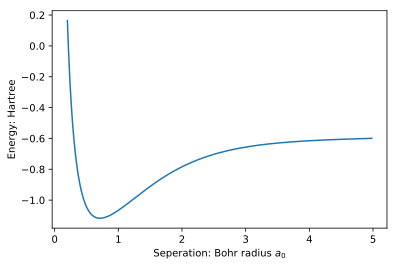

In [76]:
#energy curve of H2!
plt.plot(nucsep,energies)
plt.xlabel("Seperation: Bohr radius $a_0$")
plt.ylabel("Energy: Hartree")
plt.show()

In [77]:
min(energies) 

-1.11744507

### Classical exact eigensolver <a class="anchor" id="exact">

In [78]:
### function takes hamiltonian, returns exact eigenvalue. 

def exact_eig(Ham):
    Nbits = len(Ham[0][0][0])
    #define the Pauli (sigma matrices
    pauli_i = np.array([[1,0],[0,1]])
    pauli_x = np.array([[0,1],[1,0]])
    pauli_z = np.array([[1,0],[0,-1]])
    pauli_y = np.array([[0,-1j],[1j,0]])
    pauli_all = [pauli_i,pauli_x,pauli_z,pauli_y]
    final_op = np.zeros((2**Nbits,2**Nbits)).astype(complex)
    for term in Ham: 
        coef = term[1]
        op = term[0]
        matrix = pauli_all[op[:,0].T@np.array([2,1])]
        for pauli in range(1,Nbits):
            #selects the pauli matrix to add to the mix. I got a bit creative with the process, but the idea is to 
            #map the matrix indices to the index of the Pauli matrix in final_op. 
            pauli_op = pauli_all[op[:,pauli].T@np.array([2,1])]
            #add it to the mix of tensor products
            matrix = np.kron(pauli_op,matrix).astype(complex)
        #molecular Hamiltonian in the spin orbital basis
        final_op += matrix*coef
    #classical brute force
    return min(np.linalg.eig(final_op)[0])

In [79]:
#Hamiltonian obtained from two qubit reduced parity mapped H2 integrals, nuclear separation 0.735. 
Ham = [[np.array([[0,0],[1,1]]),0.18093119978423156],[np.array([[1,1],[0,0]]),-0.01128010425623538],[np.array([[0,0],[0,0]]),-1.0523732457728594],[np.array([[1,0],[0,0]]),0.39793742484318034],[np.array([[0,1],[0,0]]),-0.39793742484318034]]

In [81]:
exact_eig(Ham) + molecule.nuclear_repulsion_energy

(-1.1373060357534004+0j)

In [88]:
#this is the original Hamiltonian that we used to obtain the above reduced Hamiltonian. run the second line to confirm that the output is indeed Ham. 
Hamiltonian1 = get_qubit_hamiltonian([h1,h2],4,"parity")
#tqr_operator_transformation(Hamiltonian1,[[1,3],[1,0]],4)

In [86]:
#this confirms that our two-qubit reduction method does indeed give the same result as the original Hamiltonian. 
exact_eig(Hamiltonian1) + molecule.nuclear_repulsion_energy

(-1.1373060357534008+0j)

In [89]:
def h2_exact(sep):
    h2= PySCFDriver("H 0 0 0; H 0 0 " + str(sep), unit=UnitsType.ANGSTROM, basis='sto3g').run()

    nre = h2.nuclear_repulsion_energy

    integrals = [h2.one_body_integrals,h2.two_body_integrals]
    
    Ham = get_qubit_hamiltonian(integrals, 4,"jordan_wigner")
    
    return exact_eig(Ham) + nre

In [90]:
h2_exact(0.735)

(-1.1169989967540048+0j)

In [1334]:
#computes the exact ground state energies. NOT WORKING correctly. 
nucsep = np.arange(0.2,5.0,0.02)
exact_energies = np.array([])
for sep in nucsep:
    exact_energies = np.append(exact_energies,h2_exact(sep))

/Users/chenshuoma/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


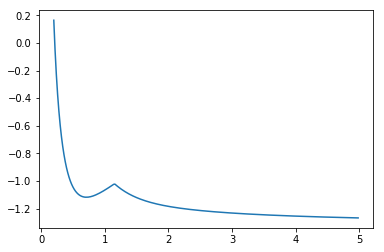

In [1341]:
#THIS RIGHT HERE ISN'T WORKING RIGHT!! IT SHOWS A DIP IN THE CURVE AND I HAVE ABSOLUTELY NO IDEA WHY. 
plt.plot(nucsep,exact_energies)
plt.show()

$\color{red}{\text{DIVISION LINE: BELOW LIES DEMONSTRATION CODE FOR SECTIONS PRIOR TO IMPLEMENTATIONS}}$

$\color{magenta}{\text{I didn't really know how to implement any of the stuff above when I wrote these, but they still are results of honest work~}}$

In [3]:
import numpy as np
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from qiskit_textbook.tools import array_to_latex
from qiskit import *
import re
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from math import pi

### Table of Contents

* [Energy Measurement](#energymeas)
    * [Section 5: Hardware Efficient trial state](#hets)
    * [Section 4 Demo: UCCSD](#uccsd)

* [My Implementation of UCCSD (to be modified for original work)](#original)

* [Section 5: Qubit reduction demo](#demo)


# Energy measurement <a class="anchor" id="energymeas"></a>

## Measurement in Hamiltonian's Pauli Basis, using hardware efficient trial state in chapter 5 (figure 9,10) <a class="anchor" id="hets"></a>

### Molecular Hydrogen with parity mapping and interatomic distance 0.741 a: Hamiltonian maps to (-1.0523732)*1 + (0.39793742)*iz + (-0.3979374)*zi + (-0.0112801)*zz + (0.18093119)*xx. Thus we create functions which measure in these bases. 

In [5]:
#pretty outputs
%config InlineBackend.figure_format = 'svg'

In [6]:
simulator = Aer.get_backend('qasm_simulator')
#performs measurement 
def measure_zz_circuit(given_circuit):
    zz_meas = given_circuit.copy()
    zz_meas.measure_all()
    return zz_meas

#fixes the output format of qiskit's "counts" function. ignore this part. 
def complement(counts):
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 
    return counts
    
#measures the ZZ-expectation value from ten thousand shots by default
def measure_zz(given_circuit, num_shots = 10000):
    zz_meas = measure_zz_circuit(given_circuit)
    result = execute(zz_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(zz_meas)
    complement(counts)
    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    zz = counts['00'] + counts['11'] - counts['01'] - counts['10']
    zz = zz / total_counts
    return zz

    
#measures the ZIexpectation value from ten thousand shots by default
def measure_zi(given_circuit, num_shots = 10000):    
    zz_meas = measure_zz_circuit(given_circuit)   
    result = execute(zz_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(zz_meas)
    complement(counts)
    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    zi = counts['00'] - counts['11'] + counts['01'] - counts['10']
    zi = zi / total_counts 
    return zi

    
#measures the IZ-expectation value from ten thousand shots by default
def measure_iz(given_circuit, num_shots = 10000):
    zz_meas = measure_zz_circuit(given_circuit)    
    result = execute(zz_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(zz_meas)
    complement(counts)
    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    iz = counts['00'] - counts['11'] - counts['01'] + counts['10']
    iz = iz / total_counts
    return iz
    
    
#measures the XX-expectation value from ten thousand shots by default
def measure_xx_circuit(given_circuit):
    xx_meas = given_circuit.copy()
    for i in range(2):
        #transform into X-basis before Z measurement. same effect as an X measurement. 
        xx_meas.h(i)
    xx_meas.measure_all()
    return xx_meas

def measure_xx(given_circuit, num_shots = 10000): 
    xx_meas = measure_xx_circuit(given_circuit)    
    result = execute(xx_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(xx_meas)
    complement(counts)
    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    xx = counts['00'] + counts['11'] - counts['01'] - counts['10']
    xx = xx / total_counts    
    return xx

In [7]:
# tracing (H\rho) and getting the energy expectation value for a trial state

def get_energy(given_circuit, num_shots = 10000):
    
    zz = measure_zz(given_circuit, num_shots = num_shots)
    iz = measure_iz(given_circuit, num_shots = num_shots)
    zi = measure_zi(given_circuit, num_shots = num_shots)
    xx = measure_xx(given_circuit, num_shots = num_shots)
    
    #the sum represents the trace
    energy = (-1.0523732)*1 + (0.39793742)*iz + (-0.3979374)*zi + (-0.0112801)*zz + (0.18093119)*xx
    
    return energy

In [8]:
#python COBYLA does not support a callback function, so we'll make it print the optimization parameters everytime an energy is evaluated. 
def energy_call_back(x,num_shots=10000):
    energy = get_energy(ABHINAV(QuantumCircuit(2),2,[x[0],x[1]],2),num_shots)
    print("[",x[0],",",x[1],"]",",")
    return energy

In [9]:
# energy measurement for parameter vector x
def energy(x,num_shots=10000):
    if len(x)!=2:
        raise ValueError("wrong number of parameters bruh")
    energy = get_energy(ABHINAV(QuantumCircuit(2),2,[x[0],x[1]],2),num_shots)
    return energy

In [10]:
#hardware efficient variational form: layer of rotations with entanglements
def ABHINAV(qc,nbits,theta,n):
    for i in range(n):
        for angle in range(len(theta)):
            for qubit in range(nbits):
                qc.ry(theta[angle],qubit)
                qc.rz(theta[angle],qubit)
            for qubit in range(nbits-1):
                qc.cx(qubit,qubit+1)
            qc.barrier()
    for qubit in range(nbits):
        qc.ry(theta[angle],qubit)
        qc.rz(theta[angle],qubit)
    return qc

In [12]:
# #energy surface for hardware efficient trial state. 

# #takes forever, DONT RUN unless you don't wanna run anything below...
# npoints = 64
# density = 0.05

# x = arange(0,3.2,density)
# y = arange(0,3.2,density)
# X,Y = meshgrid(x, y) # grid of point
# matrix = np.zeros((npoints,npoints))
# for i in range(npoints):
#     for j in range(npoints):
#         matrix[i,j] = energy([i*density,j*density],500)

In [13]:
# run the COBYLA optimization algorithm with starting point [0,0], while printing all the parameters
#where an energy evaluation is made. 

# x0=[0,0]
# minimize(energy_call_back, x0, method='COBYLA', tol=1e-4)

### store the array printed above and define: x1 = array[:,0] and y1 = array[:,1]. This is all because COBYLA does not have. callback...

In [21]:
#replicates the optimization path figure. 

z_min, z_max = np.abs(matrix).min(), np.abs(z).max()

fig, ax = plt.subplots()
ax.set_xlim(0,3.2)
ax.set_ylim(0,3.2)
c = ax.pcolormesh(X, Y, matrix, cmap='RdBu')
ax.set_title('Heat Map')
d = ax.contour(X, Y, matrix,levels=np.arange(-1.8, -0.5, 0.1), cmap="RdBu")
e = ax.plot(y1,x1,color="green")
f = ax.scatter(y1,x1,marker = "*", zorder=3)
ax.axis([X.min(), X.max(), Y.min(), Y.max()])
fig.colorbar(c, ax=ax)
plt.show()

-1.838817850936

In [14]:
### the energy of H2 molecule, in hartrees, of one of the optimization results. The results may vary a bit, since the energy measurements are probabilistic. 
energy([-0.02821171,  1.54944105])

-1.8357245178919999

## Energy Measurement using UCCSD's implementation of, well, UCCSD. (figure 7) <a class="anchor" id="uccsd"></a>

In [14]:
#define Hartree Fock initial state
init_state = HartreeFock(num_orbitals=4, num_particles=2, qubit_mapping='parity')

#Construct UCCSD variational form
UCCSD_var_form = UCCSD(num_orbitals=4, num_particles=2, qubit_mapping='parity',
                      excitation_type='s', method_singles="beta",
                      initial_state=init_state,reps=2)

In [15]:
def energy1(var,num_shots=10000):
    return get_energy(UCCSD_var_form.construct_circuit(var),num_shots = num_shots)

In [17]:
#energy surface for UCCSD var form. 

#takes forever, DONT RUN (unless you really don't trust me), PERIOD. 

# npoints = 64
# density = 0.05

# x = arange(0,3.2,density)
# y = arange(0,3.2,density)
# X,Y = meshgrid(x, y) # grid of point
# matrix = np.zeros((npoints,npoints))
# for i in range(npoints):
#     for j in range(npoints):
#         matrix[i,j] = energy1([i*density,j*density],500)

In [35]:
#optimizing using a different variational form. Should converge to ~-1.835 Hartrees. 

#The parameters have NO PHYSICAL MEANING!!!

x0=[0,0]
minimize(energy1, x0, method='COBYLA', tol=1e-4)

     fun: -1.8342236400839997
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([0.01619836, 0.00981173])

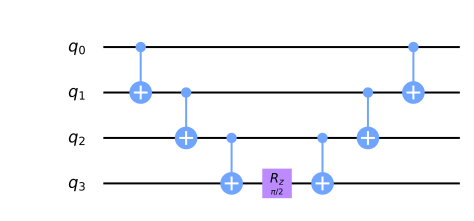

In [17]:
#the phase gadget, some demo figure
from qiskit import QuantumCircuit
from math import pi
qc = QuantumCircuit(4)
for i in range(3):
    qc.cx(i,i+1)
qc.rz(pi/2,3)
for i in range(3,0,-1):
    qc.cx(i-1,i)
qc.draw("mpl")

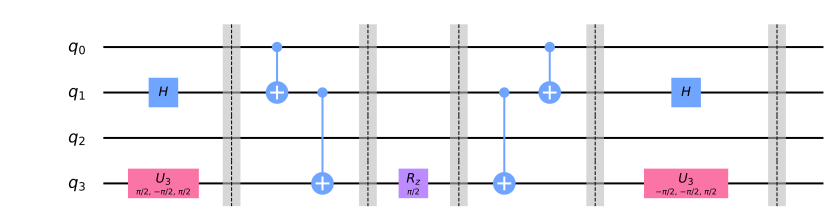

In [28]:
#the arbitrary phase gadget, using the phase_gadget function defined BELOW
phase_gadget(QuantumCircuit(4),4,"ZXIY",pi/2).draw("mpl")

# My implementation of UCCS <a class="anchor" id="original"></a>

In [18]:
#implements the product of a creation and annihilation operator in jordan wigner basis
def operator_product(excitation_list,nbits):
    #annihilation operator's position. 
    
    # in general, the excitation_list should always be a list of increasing indices (and thus is a list of excitations). 
    
    # thus we assume the creation operator is placed after the annihilation operator in the cluster operator.
    a = excitation_list[0]
    
    #annihilation operator's location
    c = excitation_list[1]
    str1 = str2 = ""
    
    ## product of two identical pauli gates cancel
    for qubit in range(a): 
        str1 += "I"
        str2 += "I"
    
    # append the computed pauli strings 
    str1 += "Y"
    str2 += "X"
    
    # not cancelled Z operators in between 
    for qubit in range(c-a-1):
        str1 += "Z"
        str2 += "Z"
        
    # again, append the paulis
    str1 += "X"
    str2 += "Y"
    
    #product of two identical pauli gates cancel
    for qubit in range(nbits-c-1):
        str1 += "I"
        str2 += "I"
    return [str1,str2]

In [19]:
#implements phase_gadget 2 function. exact same structure as the pseudocode.
def phase_gadget(qc,nbits,operator,alpha):
    for i in range(len(operator)):
        if operator[i] == "X":
            qc.h(i)
        elif operator[i] == "Y":
            qc.u3(pi/2,-pi/2,pi/2,i)
    #qc.barrier()
    ind = [m.start() for m in re.finditer(r"X|Y|Z", operator)]
    for i in range(len(ind)-1):
        qc.cx(ind[i],ind[i+1])
   # qc.barrier()
    qc.rz(alpha,ind[-1])
    #qc.barrier()
    for i in range(len(ind)-1,0,-1):
        qc.cx(ind[i-1],ind[i])
   # qc.barrier()
    for i in range(len(operator)):
        if operator[i] == "X":
            qc.h(i)
        elif operator[i] == "Y":
            qc.u3(-pi/2,-pi/2,pi/2,i)
    #qc.barrier()
    return qc

In [20]:
# UCC singles. 

def single_excitation(var,
                      num_orbitals,
                      num_particles,
                      mapping = "jordan_wigner", 
                      method_singles = "beta",
                      excitation_type = "s",
                     reps = 1):
    
    if isinstance(var,int) or isinstance(var,float):
        var = [var]
        
    var_multiplier = 1 if method_singles == "beta" else 2
    
    init_state = HartreeFock(num_orbitals=num_orbitals, 
                             num_particles=num_particles, 
                             qubit_mapping=mapping)

    HartreeFock_circuit = init_state.construct_circuit('circuit')
    
    HartreeFock_circuit.barrier()
    
    #compute the list of excitations
    excitations = UCCSD.compute_excitation_lists(num_particles=num_particles, 
                                                 num_orbitals=num_orbitals, 
                                                 same_spin_doubles=False,
                                                 method_singles=method_singles, 
                                                 method_doubles='ucc',
                                                 excitation_type=excitation_type)
    
    singles = excitations[0]
    num_gadgets = len(singles)
    #if len(var) != var_multiplier*reps*num_gadgets:
      #  raise ValueError("wrong number of variables")
        
    if method_singles == "beta":
        #for each possible excitation, compute the corresponding Pauli strings and put them into phase gadgets
        for excitation in singles:
            for rep in range(0,len(var),var_multiplier):
                pauli_strings = operator_product(excitation,num_orbitals)
        
                phase_gadget(HartreeFock_circuit,num_orbitals,pauli_strings[0],var[rep])
        
                phase_gadget(HartreeFock_circuit,num_orbitals,pauli_strings[1],-var[rep])
    #alpha just means both electrons are excited.         
    if method_singles == "alpha":
        for excitation_ in range(0,len(singles),2):
            excitation = singles[excitation_]
            for rep in range(0,len(var),var_multiplier):
                pauli_strings = operator_product(excitation,num_orbitals)
        
                phase_gadget(HartreeFock_circuit,num_orbitals,pauli_strings[0],var[rep])
        
                phase_gadget(HartreeFock_circuit,num_orbitals,pauli_strings[1],-var[rep])
            
        for excitation_ in range(1,len(singles),2):
            excitation = singles[excitation_]
            for rep in range(1,len(var),var_multiplier):
                pauli_strings = operator_product(excitation,num_orbitals)
        
                phase_gadget(HartreeFock_circuit,num_orbitals,pauli_strings[0],var[rep])
        
                phase_gadget(HartreeFock_circuit,num_orbitals,pauli_strings[1],-var[rep])
            
    return HartreeFock_circuit

In [112]:
qc = single_excitation([1,2,3,4],4,2,method_singles = "alpha",reps = 2)

two_qubit_reduction only works with parity qubit mapping but you have jordan_wigner. We switch two_qubit_reduction to False.


In [114]:
# drawing MY implementation of UCC single excitation variational form with jordan-wigner mapped hydrogen. 

# I need to work on qubit tapering. measuring a hundred terms in four qubits takes waaaay longer than 5 terms in 2 qubits. 
qc.draw("mpl").savefig("demo.png")

# Two qubit reduction Demo <a class="anchor" id="demo"></a>

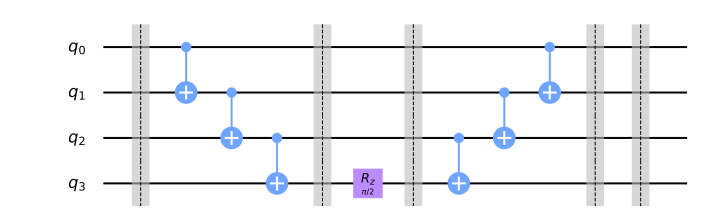

In [45]:
#section 5.1.3 figures 

#example 1 before reduction
qc = QuantumCircuit(4)
phase_gadget(qc,4,"ZZZZ",pi/2).draw("mpl")

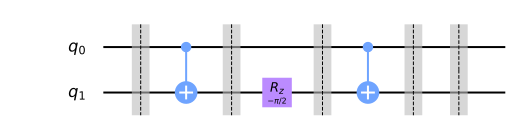

In [46]:
#after
qc = QuantumCircuit(2)
phase_gadget(qc,2,"ZZ",-pi/2).draw("mpl")

In [49]:
#example 2 
qc = QuantumCircuit(4)
phase_gadget(qc,4,"XZYI",pi/2).draw("mpl")

In [50]:
qc = QuantumCircuit(2)
phase_gadget(qc,2,"XY",-pi/2).draw("mpl")

In [51]:
#example 3
qc = QuantumCircuit(4)
phase_gadget(qc,4,"XIYZ",pi/2).draw("mpl")

In [52]:
qc = QuantumCircuit(2)
phase_gadget(qc,2,"XY",pi/2).draw("mpl")

### 3-Qubit circuit reduction toy example, eq 5.1.3.2 

In [104]:
backend = Aer.get_backend("unitary_simulator")

In [105]:
qc = QuantumCircuit(3)
qc.cx(0,1)
qc.cx(1,2)
qc.rz(pi/2,2)
qc.cx(1,2)
qc.cx(0,1)
unitary = execute(qc,backend).result().get_unitary()

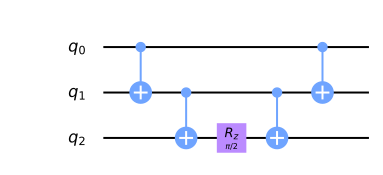

In [106]:
qc.draw("mpl")

In [107]:
array_to_latex(unitary)

<IPython.core.display.Math object>

In [34]:
qc = QuantumCircuit(4)
alpha = pi/2
phase_gadget(qc,4,"IIYX",alpha)
phase_gadget(qc,4,"IIXY",-alpha)
qc.draw('mpl').savefig("commutativity_demo_lmao.pdf",dpi = 400)

In [121]:
qc = QuantumCircuit(4)
alpha = pi/2
phase_gadget(qc,4,"IIXY",-alpha)
phase_gadget(qc,4,"IIYX",alpha)
qc.draw("mpl").savefig("commutativity_demo_1.png",dpi = 300)